# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

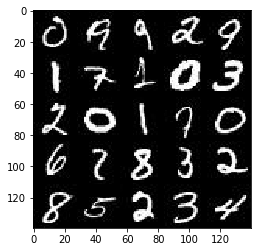

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

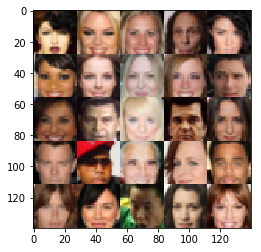

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu1 = tf.maximum(x1 * 0.1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu2 = tf.maximum(x2 * 0.1, x2)
        y2 = tf.layers.batch_normalization(x2, training=True)

        x3 = tf.layers.conv2d(y2, 256, 5, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same')
        relu3 = tf.maximum(x3 * 0.1, x3)
        y3 = tf.layers.batch_normalization(x3, training=True)

        flattened = tf.reshape(y3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1_reshape = tf.reshape(x1, (-1, 7, 7, 256))
        relu1 = tf.maximum(x1_reshape * 0.1, x1_reshape)
        x1_norm = tf.layers.batch_normalization(relu1, training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1_norm, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu2 = tf.maximum(x2 * 0.1, x2)
        x2_norm = tf.layers.batch_normalization(relu2, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2_norm, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu3 = tf.maximum(x3 * 0.1, x3)
        x3_norm = tf.layers.batch_normalization(relu3, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x3_norm, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real, d_real_logits = discriminator(input_real)
    d_fake, d_fake_logits = discriminator(g_model, reuse=True)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real) * (1 - 0.1)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake)))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies([opt for opt in update_ops if opt.name.startswith('discriminator')]):
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies([opt for opt in update_ops if opt.name.startswith('generator')]):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt_train, g_opt_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt_train, g_opt_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt_train, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt_train, feed_dict={input_z: batch_z})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 2.0730
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 3.0565
Epoch 1/2... Discriminator Loss: 0.3983... Generator Loss: 3.6363
Epoch 1/2... Discriminator Loss: 0.4263... Generator Loss: 3.4254
Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 3.6925
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 3.6577
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 5.1161
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 4.6906
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 4.1599
Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 4.0712


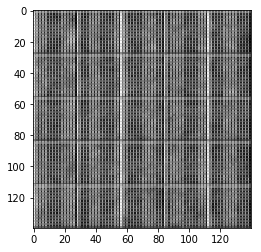

Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 4.0827
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 4.4535
Epoch 1/2... Discriminator Loss: 0.3488... Generator Loss: 4.5396
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 4.1139
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 3.8034
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 5.0335
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 4.2129
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 4.3655
Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 3.9794
Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 4.5792


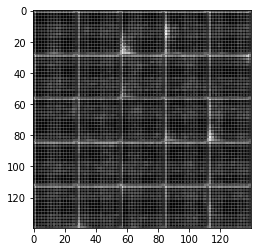

Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 4.1191
Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 3.2812
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 2.5158
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 6.9583
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 2.2623
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 2.3380
Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 1.1627


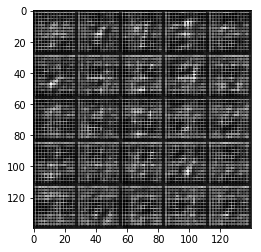

Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.1658
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.5505
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.8801
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 1.9685
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 0.8946


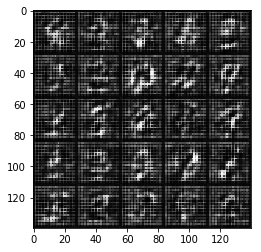

Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 2.2285
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.9098
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.7772
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 2.5749
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.4049
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 2.1005


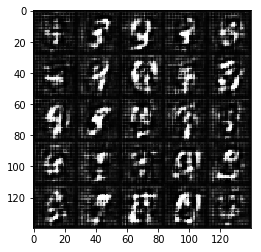

Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.7333
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.7023
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.4327
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.9414
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.8034
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.4399
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.6971


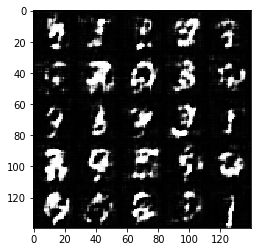

Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 2.5557
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.7144
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.1514
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.7215


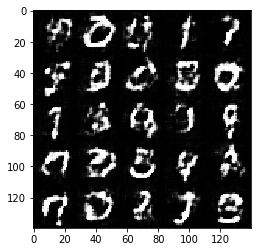

Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.3754
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.1413
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 2.0582
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.0782


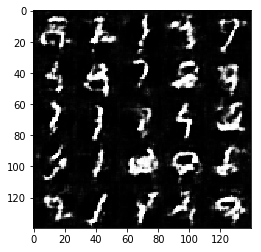

Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.3334
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.5609


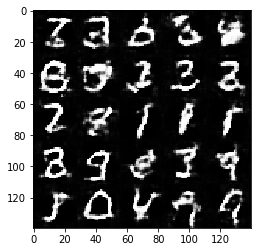

Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.4155
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.7690
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 1.2196
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.0112


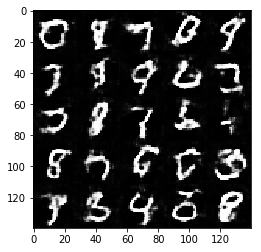

Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.4913
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.2041


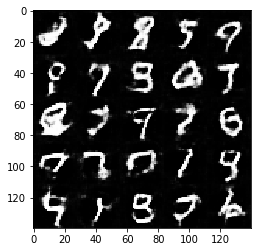

Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 1.7486
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 1.7689
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.1465
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.0328
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.4980
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.1135


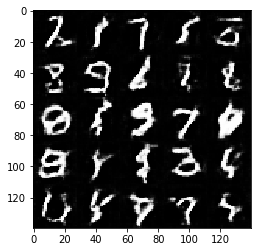

Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.2573


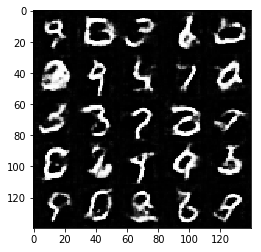

Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 1.0305... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.9987
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.4754


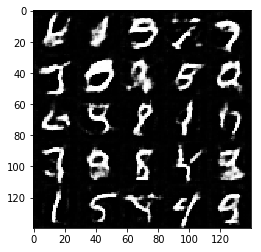

Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.3070
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.4010
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 2.2854
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.1637


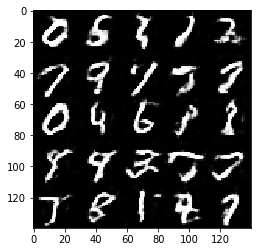

Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.8742


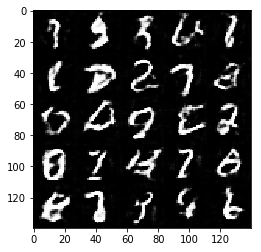

Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.4568
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 2.2326
Epoch 2/2... Discriminator Loss: 2.2774... Generator Loss: 3.4153
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.8746


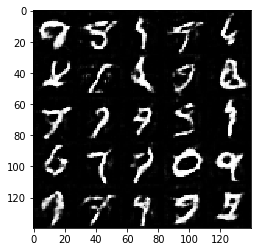

Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.4199
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.5673
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.5565


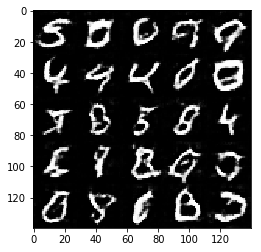

Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 2.0631
Epoch 2/2... Discriminator Loss: 1.6784... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3381
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8666


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.4774
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 3.4289
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 4.0715
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 2.6075
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 4.1178
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 2.2397


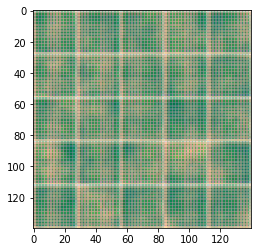

Epoch 1/1... Discriminator Loss: 1.9941... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.1553
Epoch 1/1... Discriminator Loss: 2.8761... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 1.9459... Generator Loss: 5.2842
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 2.1169
Epoch 1/1... Discriminator Loss: 1.8278... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.4784


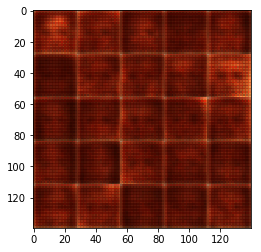

Epoch 1/1... Discriminator Loss: 2.0639... Generator Loss: 4.5168
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 2.0719... Generator Loss: 0.2821


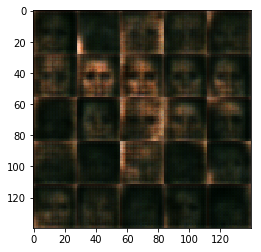

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 1.6417
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.8502... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 1.7742... Generator Loss: 0.4280


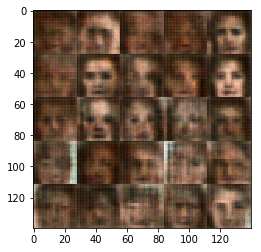

Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.7009


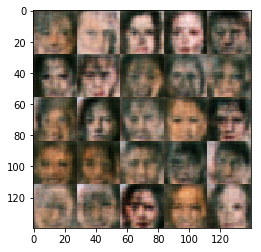

Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6874


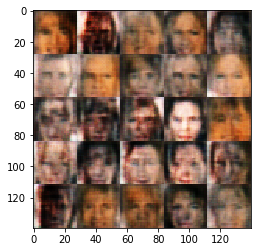

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7705


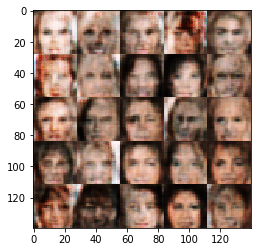

Epoch 1/1... Discriminator Loss: 2.2026... Generator Loss: 0.2382
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6468


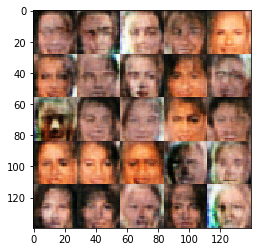

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9985


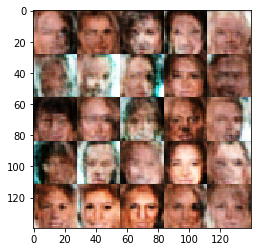

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5091


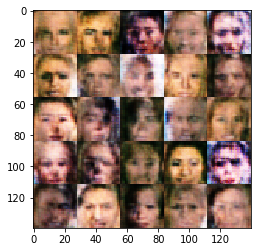

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7755


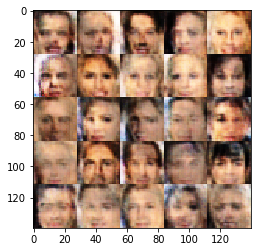

Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7933


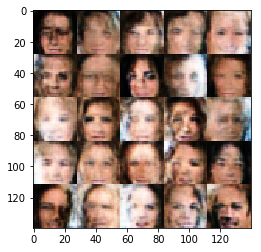

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.0236


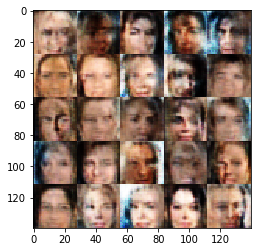

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7884


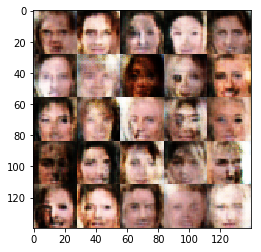

Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7265


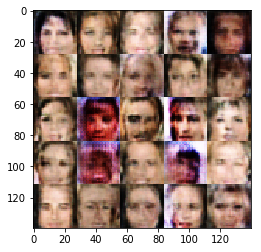

Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6938


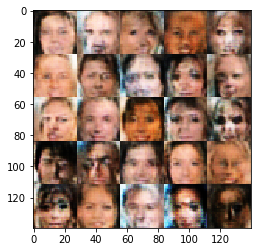

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0608


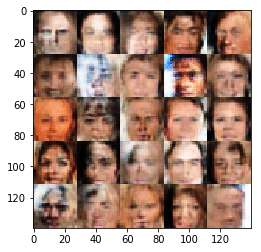

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.0791


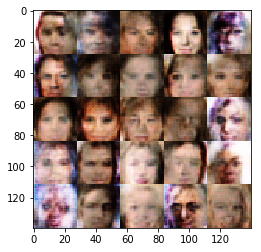

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8086


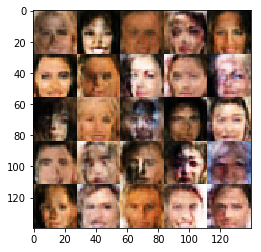

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7754


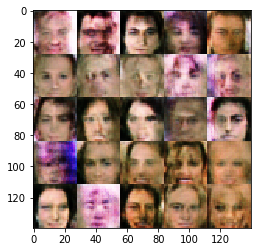

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.9201


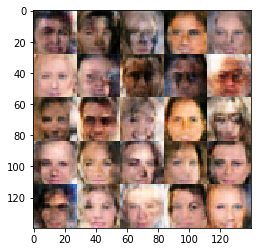

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5343


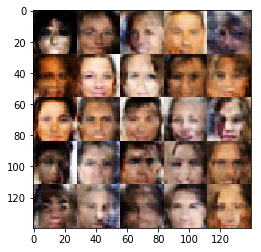

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9859


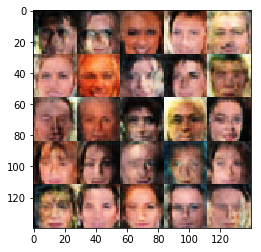

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.9094


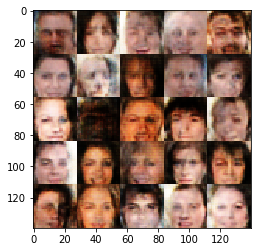

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9340


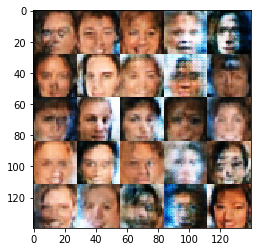

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7467


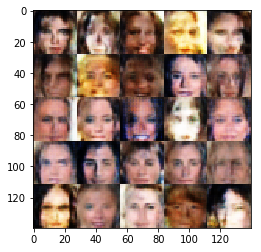

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.8879... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8194


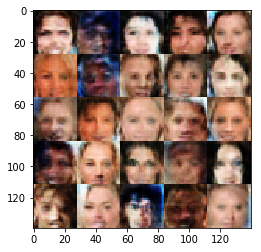

Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7792


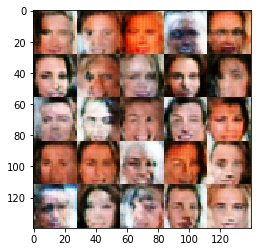

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8024


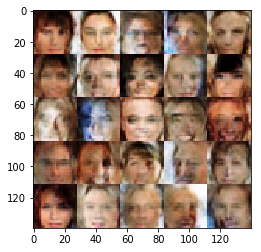

Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.8412


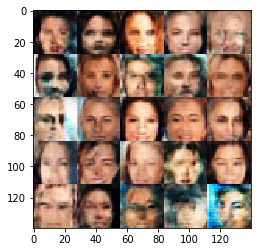

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9104


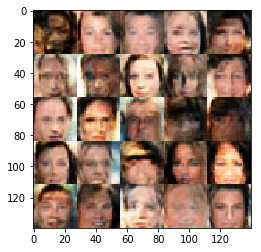

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7917


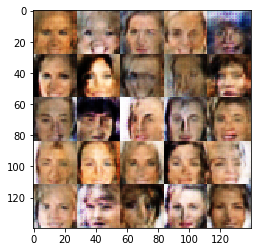

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.7392... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7038


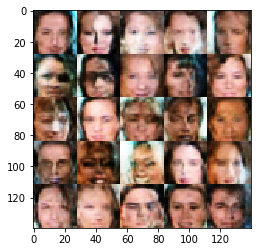

Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6337


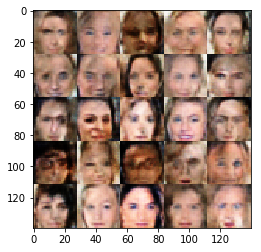

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6487


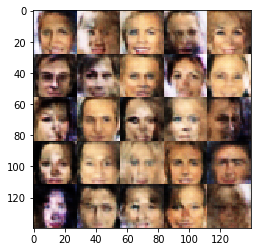

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7084


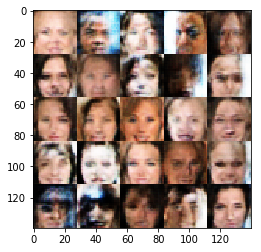

Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7514


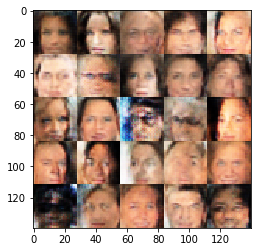

Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7507


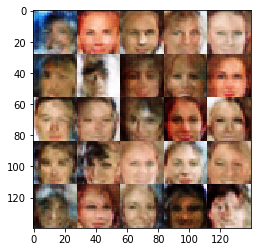

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9099


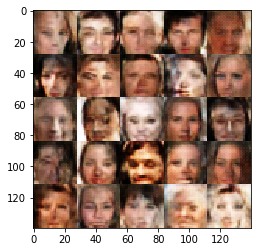

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7121


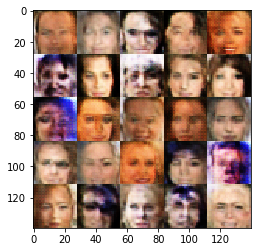

Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.7048


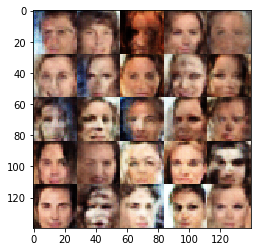

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7745


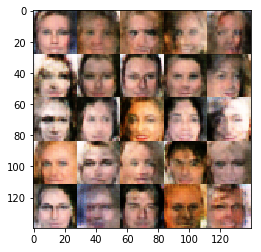

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7141


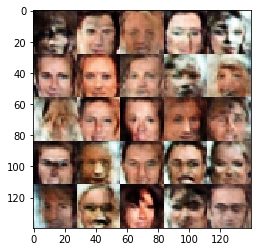

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8558


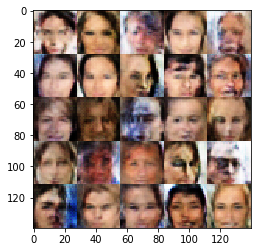

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8058


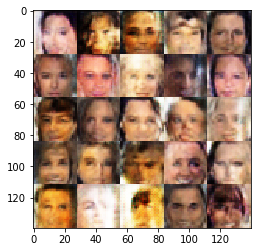

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6878


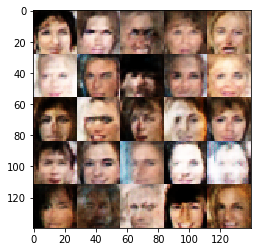

Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8001


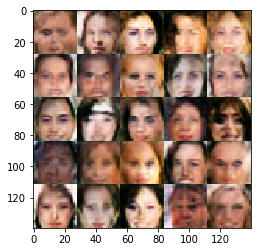

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8239


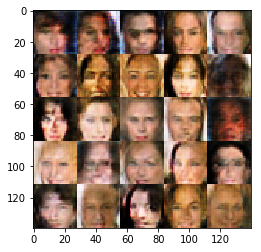

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7938


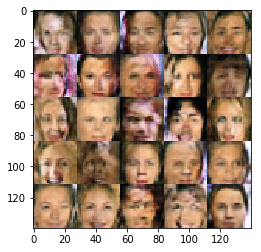

Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9447


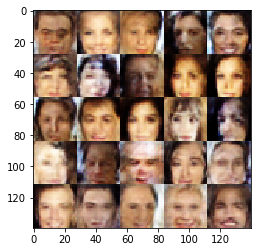

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8576


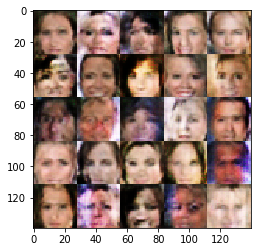

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8043


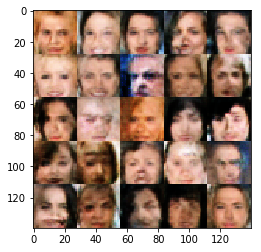

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7753


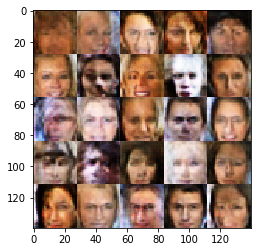

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6977


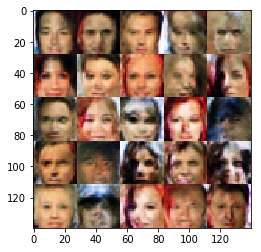

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8295


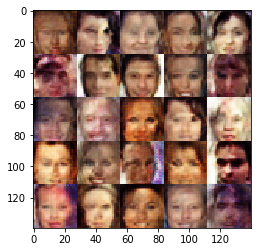

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6238


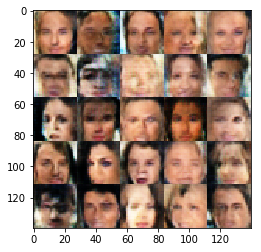

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7400


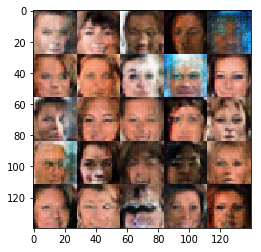

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8298


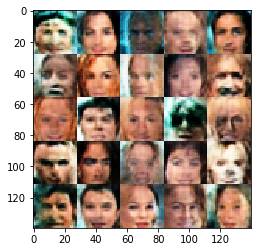

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.9020


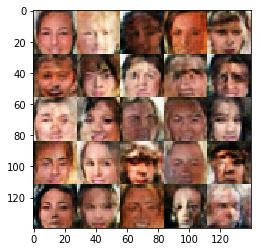

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.8139


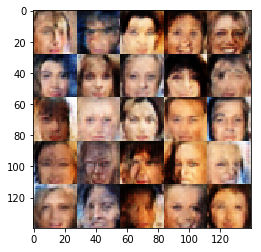

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8161


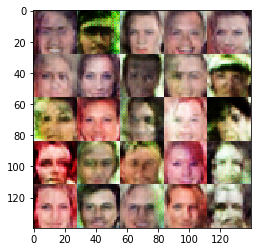

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7143


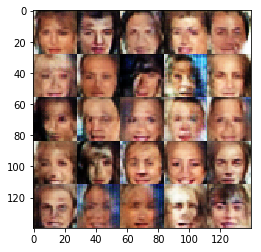

Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8733


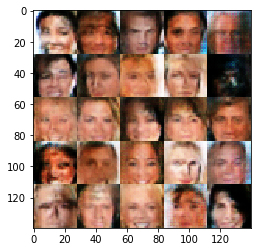

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.6061


In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.